This notebook is my take on the Kaggle [competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) on histopahalogic cancer detection. In this competition an algorithm must be created to identify metastatic cancer in small image patches taken from larger digital pathology scans. In this notebook we will first perform Exploratory Data Analysis (EDA), make a design for a convolutional neural network, train it and evaluate the performance. Finally we will use the generated model to predict outcomes on a test set provided by the competition.

Import required Python modules

In [81]:
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, BatchNormalization

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from glob import glob
import cv2,os

Read the training data labels

In [2]:
DATADIR = r'assignment/histopathologic-cancer-detection/train/'

In [3]:
df_train_data = pd.read_csv('assignment/histopathologic-cancer-detection/train_labels.csv',dtype=str)
# append file extension
df_train_data.id = df_train_data.id + '.tif'

Define function to display images from training folder

In [4]:
def read_img (filename) : 
    filepath = DATADIR + filename
    return plt.imread(filepath)
    
def show_img (image) :
    plt.figure()
    plt.imshow(image)
    
def read_show_img (filename) :
    I = read_img(filename)
    show_img(I)

25687     None
123253    None
7908      None
158181    None
182821    None
67824     None
64816     None
198655    None
210638    None
115225    None
Name: id, dtype: object

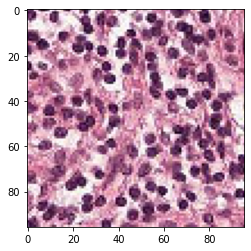

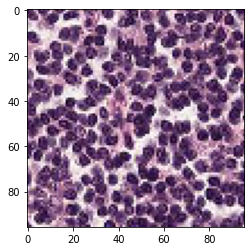

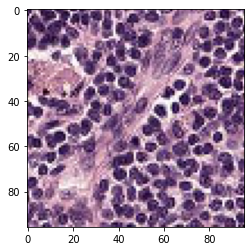

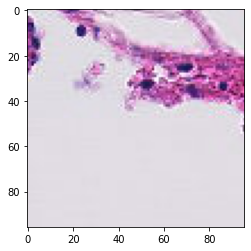

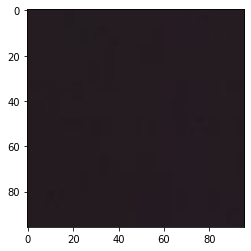

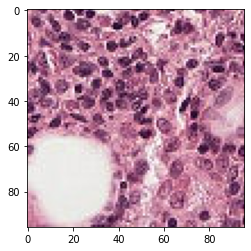

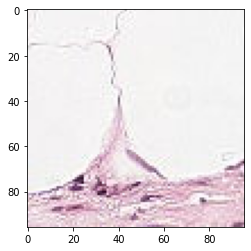

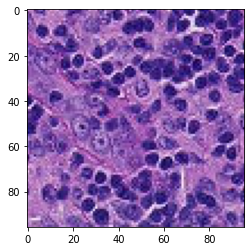

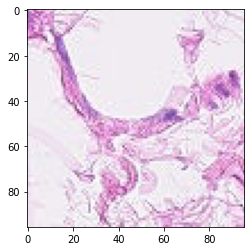

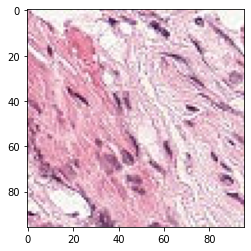

In [5]:
rand_1 = df_train_data[df_train_data.label=='1'].sample(10)
rand_0 = df_train_data[df_train_data.label=='0'].sample(10)

rand_0.id.apply(read_show_img)

43034     None
127693    None
154818    None
75107     None
52943     None
54442     None
12658     None
40477     None
83151     None
19224     None
Name: id, dtype: object

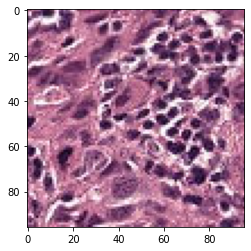

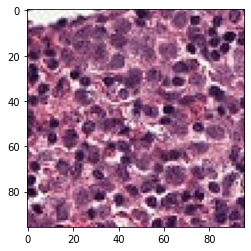

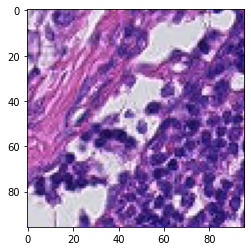

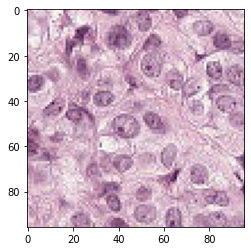

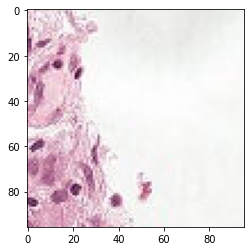

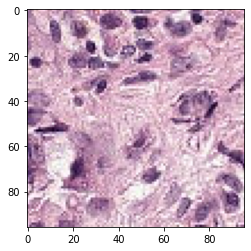

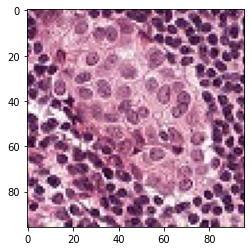

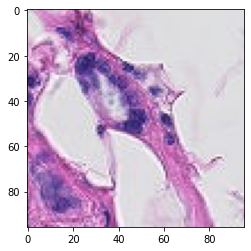

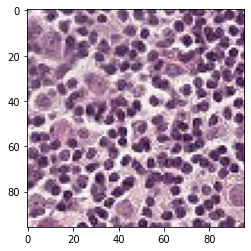

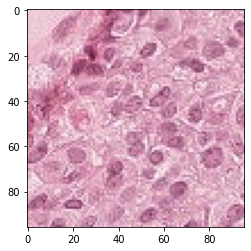

In [6]:
rand_1.id.apply(read_show_img)

Check if the training data is balanced, and check the size of individual images

<AxesSubplot:>

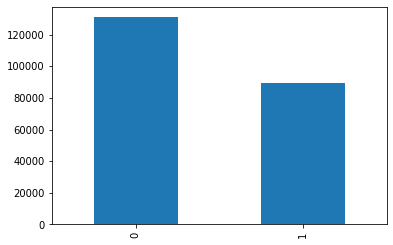

In [7]:
df_train_data.label.value_counts().plot.bar()

In [8]:
rand_img = df_train_data.sample(1)
I = rand_img.id.apply(read_img)
I.iloc[0].shape

(96, 96, 3)

So the size of the images is 96 by 96, with 3 values for colors R, G, B. In the description of the data I read the following: "In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."

During the EDA I've noticed the images contain several circular shapes of varying size. In order to capture the different shapes I will use convolution layers. Since the outer part of the images is not used for the labeled examples, I can use layers without padding. Since we are looking for binary classification, the sigmoid function will be used for the final activation layer. This will be my project plan:
- prepare input data
- define several models; vary the learning rate, max vs average pooling and batch normalization vs dropout 
- fit the models, and evaluate the accuracy and auc of the validation data
- choose the model with peak performance for the test dataset and make the submission to Kaggle

In order to be able to train the model, we need to prepare the input data

In [9]:
batch_size = 32
img_height = 96
img_width = 96

In [10]:
split_size = 0.2
seed = 1337

In [31]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=split_size)

train_set = datagen.flow_from_dataframe(
    dataframe  = df_train_data,
    directory  = DATADIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'training',
    batch_size = batch_size,
    seed       = seed,
    shuffle    = True,
    class_mode = 'binary',
    target_size = (96,96))

valid_set = datagen.flow_from_dataframe(
    dataframe  = df_train_data,
    directory  = DATADIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'validation',
    batch_size = batch_size,
    seed       = seed,
    shuffle    = True,
    class_mode = 'binary',
    target_size = (96,96))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Define model parameters

In [32]:
train_steps = np.ceil(len(train_set) / batch_size)
val_steps = np.ceil(len(valid_set) / batch_size)

print('Steps:')
print('Train: %d | Validation: %d ' %(train_steps, val_steps))

Steps:
Train: 172 | Validation: 43 


Define model

In [13]:
kernel_size     = 3
pool_size       = 2

first_filters   = 32
second_filters  = 64
third_filters   = 128

dropout_conv = 0.3
dropout_dense = 0.3


In [14]:
def model_cnn_max_drop():
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96,96,3)))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model    

In [15]:
def model_cnn_avg_drop():
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96,96,3)))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(AveragePooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    
    model.add(AveragePooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    
    model.add(AveragePooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model    

In [16]:
def model_cnn_max_batch():
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96,96,3)))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(BatchNormalization())
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(BatchNormalization())
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model    

In [17]:
def model_cnn_avg_batch():
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96,96,3)))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(AveragePooling2D(pool_size = pool_size)) 
    model.add(BatchNormalization())
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    
    model.add(AveragePooling2D(pool_size = pool_size))
    model.add(BatchNormalization())
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    
    model.add(AveragePooling2D(pool_size = pool_size))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model 

In [33]:
h = {}

for i,lr in enumerate([0.0001,0.001]) :

    optimizer       = Adam(learning_rate=lr)
    loss            = 'binary_crossentropy'
    metric          = 'accuracy'
    epochs          = 7

    for j,model in enumerate([model_cnn_max_drop(),model_cnn_avg_drop(),model_cnn_max_batch(),model_cnn_avg_batch()]):
        model.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

        t = time.time()
        h[i,j] = model.fit(    x                = train_set,
                      steps_per_epoch  = train_steps,
                      validation_data  = valid_set,
                      validation_steps = val_steps,
                      epochs           = epochs)

        print('Fitting model in %.2f secs' % (time.time()-t))

Epoch 1/7
172/172 [==============================] - 97s 562ms/step - loss: 0.6317 - accuracy: 0.6226 - auc_12: 0.6859 - val_loss: 0.5107 - val_accuracy: 0.7638 - val_auc_12: 0.8363
Epoch 2/7
172/172 [==============================] - 105s 610ms/step - loss: 0.5182 - accuracy: 0.7609 - auc_12: 0.8140 - val_loss: 0.5289 - val_accuracy: 0.7536 - val_auc_12: 0.8245
Epoch 3/7
172/172 [==============================] - 98s 567ms/step - loss: 0.4923 - accuracy: 0.7720 - auc_12: 0.8332 - val_loss: 0.4842 - val_accuracy: 0.7783 - val_auc_12: 0.8533
Epoch 4/7
172/172 [==============================] - 102s 595ms/step - loss: 0.4922 - accuracy: 0.7762 - auc_12: 0.8344 - val_loss: 0.4832 - val_accuracy: 0.7812 - val_auc_12: 0.8479
Epoch 5/7
172/172 [==============================] - 100s 579ms/step - loss: 0.4828 - accuracy: 0.7825 - auc_12: 0.8402 - val_loss: 0.4776 - val_accuracy: 0.7827 - val_auc_12: 0.8612
Epoch 6/7
172/172 [==============================] - 99s 575ms/step - loss: 0.4795 - ac

Epoch 3/7
172/172 [==============================] - 101s 585ms/step - loss: 0.4662 - accuracy: 0.7965 - auc_18: 0.8520 - val_loss: 1.5624 - val_accuracy: 0.6010 - val_auc_18: 0.7762
Epoch 4/7
172/172 [==============================] - 99s 575ms/step - loss: 0.4724 - accuracy: 0.7885 - auc_18: 0.8472 - val_loss: 0.5656 - val_accuracy: 0.7515 - val_auc_18: 0.8399
Epoch 5/7
172/172 [==============================] - 97s 565ms/step - loss: 0.4446 - accuracy: 0.7960 - auc_18: 0.8674 - val_loss: 0.6497 - val_accuracy: 0.6868 - val_auc_18: 0.7292
Epoch 6/7
172/172 [==============================] - 2320s 14s/step - loss: 0.4490 - accuracy: 0.7996 - auc_18: 0.8604 - val_loss: 0.4952 - val_accuracy: 0.7805 - val_auc_18: 0.8636
Epoch 7/7
172/172 [==============================] - 98s 567ms/step - loss: 0.4102 - accuracy: 0.8169 - auc_18: 0.8881 - val_loss: 0.4775 - val_accuracy: 0.7725 - val_auc_18: 0.8584
Fitting model in 2911.99 secs
Epoch 1/7
172/172 [==============================] - 103s 5

Train the model

In [48]:
dataframes = []

for x in range(2):
    for y in range(4):
        frame = pd.DataFrame(h[x,y].history)
        frame['xy'] = str(x) + ', ' +str(y) 
        dataframes.append(frame)
datahist = pd.concat(dataframes, axis=0, ignore_index=True)

<AxesSubplot:>

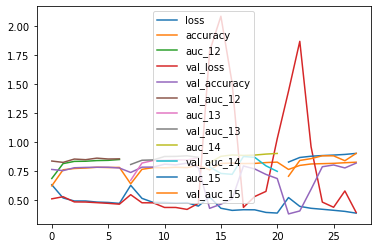

In [41]:
datahist.plot.line()

In [49]:
datahist.sort_values('val_accuracy')

,loss,accuracy,auc_12,val_loss,val_accuracy,val_auc_12,xy,auc_13,val_auc_13,auc_14,...,auc_15,val_auc_15,auc_16,val_auc_16,auc_17,val_auc_17,auc_18,val_auc_18,auc_19,val_auc_19
21,0.521716,0.763808,NaN,1.438233,0.380814,NaN,"0, 3",NaN,NaN,NaN,...,0.827412,0.705461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,0.445747,0.798510,NaN,1.866890,0.406250,NaN,"0, 3",NaN,NaN,NaN,...,0.866784,0.841303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.526296,0.760015,NaN,1.781230,0.428779,NaN,"0, 2",NaN,NaN,0.820499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0.429669,0.815589,NaN,2.083091,0.464390,NaN,"0, 2",NaN,NaN,0.876754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.411239,0.818677,NaN,1.505467,0.509448,NaN,"0, 2",NaN,NaN,0.888312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,0.628447,0.730741,NaN,0.805940,0.537064,NaN,"1, 2",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.773047,0.558589,NaN,NaN
49,0.594702,0.718568,NaN,0.815832,0.550872,NaN,"1, 3",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777369,0.821231
54,0.456591,0.797420,NaN,0.839448,0.565407,NaN,"1, 3",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.857017,0.636092
32,0.675018,0.596839,NaN,0.686653,0.570494,NaN,"1, 0",NaN,NaN,NaN,...,NaN,NaN,0.495245,0.50000,NaN,NaN,NaN,NaN,NaN,NaN
53,0.471305,0.789244,NaN,1.599506,0.570494,NaN,"1, 3",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.847286,0.527256


From the results we can see model (0,3) has best auc score for the validation set. In general the learning rate of 0.0001 scores better, as well as average pooling and batch normalization. Checking the epoch history for the best model so far:

<AxesSubplot:>

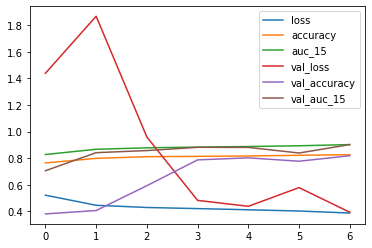

In [61]:
df = pd.DataFrame(h[0,3].history)
df.plot.line()

It seems the model training has converged pretty soon. So let's also try training the best settings so far with a lower learning rate.

In [64]:

optimizer       = Adam(learning_rate=0.00005)
loss            = 'binary_crossentropy'
metric          = 'accuracy'
epochs          = 10

model = model_cnn_avg_batch()
model.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

t = time.time()

h2 = model.fit(    x                = train_set,
              steps_per_epoch  = train_steps,
              validation_data  = valid_set,
              validation_steps = val_steps,
              epochs           = epochs,
              callbacks=[model_checkpoint_callback])

print('Fitting model in %.2f secs' % (time.time()-t))


# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/10
172/172 [==============================] - 105s 607ms/step - loss: 0.5457 - accuracy: 0.7480 - auc_21: 0.8180 - val_loss: 0.6751 - val_accuracy: 0.6628 - val_auc_21: 0.7943
Epoch 2/10
172/172 [==============================] - 108s 625ms/step - loss: 0.4668 - accuracy: 0.7907 - auc_21: 0.8593 - val_loss: 0.8679 - val_accuracy: 0.4658 - val_auc_21: 0.8387
Epoch 3/10
172/172 [==============================] - 111s 646ms/step - loss: 0.4460 - accuracy: 0.8031 - auc_21: 0.8672 - val_loss: 0.8217 - val_accuracy: 0.6453 - val_auc_21: 0.8576
Epoch 4/10
172/172 [==============================] - 1941s 11s/step - loss: 0.4421 - accuracy: 0.8043 - auc_21: 0.8722 - val_loss: 0.4886 - val_accuracy: 0.7856 - val_auc_21: 0.8770
Epoch 5/10
172/172 [==============================] - 3038s 18s/step - loss: 0.4187 - accuracy: 0.8185 - auc_21: 0.8852 - val_loss: 0.4173 - val_accuracy: 0.7965 - val_auc_21: 0.8905
Epoch 6/10
172/172 [==============================] - 105s 611ms/step - loss: 0.42

Now, after training is done, prepare the test data for submission.

In [91]:
TESTDIR = 'assignment/histopathologic-cancer-detection/test/'

In [92]:
test_set = os.listdir(TESTDIR)

In [93]:
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
test_df.head()

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


In [94]:
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory=TESTDIR,
                x_col="id",batch_size=64,seed=1234,shuffle=False,
                class_mode=None,target_size=(96,96))

Found 57458 validated image filenames.


In [95]:
STEP_SIZE_TEST=test_generator.n/2

preds = model.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)

predictions = []

for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
        
predictions[:10]

submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head()

/var/folders/p7/6v1j479d7bn9mv_1s_mktx7r0000gn/T/ipykernel_16808/1037985277.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)


28729/28729 [==============================] - 219s 8ms/step


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,1
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [96]:
submission.shape

(57458, 2)

In [97]:
submission.label.value_counts()

0    37027
1    20431
Name: label, dtype: int64

In [98]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file